In [1]:
import pandas as pd
import numpy as np
import requests
from ydata_profiling import ProfileReport
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import featuretools as ft
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [153]:
# Function to fetch data for a given date range
def fetch_hourly_data(start_date, end_date):
    url = "https://meteostat.p.rapidapi.com/point/hourly"

    querystring = {
        "lat": 24.8607,
        "lon": 67.0011,
        "alt": 8,
        "start": start_date,
        "end": end_date,
        "hourly": "temperature_2m,humidity_2m,precipitation,wind_speed_10m"
    }

    headers = {
        "x-rapidapi-key": "7e31775938msh8506793836aabe6p100cb3jsnd6155c484f96",
        "x-rapidapi-host": "meteostat.p.rapidapi.com"
    }

    # Make API request
    response = requests.get(url, headers=headers, params=querystring)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        if "data" in data:
            return data["data"]
        else:
            print(f"❌ No data found for {start_date} to {end_date}")
    else:
        print(f"❌ HTTP error {response.status_code} for {start_date} to {end_date}")
        print(response.text)
    return None

# Get today's date and calculate the start date (1 year ago)
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # 1 year ago

# Convert dates to string format (YYYY-MM-DD)
end_date_str = end_date.strftime("%Y-%m-%d")
start_date_str = start_date.strftime("%Y-%m-%d")

# Create a list to store the data
all_data = []

# Loop over the range in 30-day intervals
current_start = start_date
current_end = current_start + timedelta(days=29)

while current_start <= end_date:
    # Ensure the end date doesn't go beyond today
    if current_end > end_date:
        current_end = end_date
    
    # Format dates back to string for query
    start_str = current_start.strftime("%Y-%m-%d")
    end_str = current_end.strftime("%Y-%m-%d")
    
    # Fetch data for this interval
    data = fetch_hourly_data(start_str, end_str)
    if data:
        # Add the data to the list
        all_data.extend(data)
        print(f"✅ Data fetched from {start_str} to {end_str}")
    
    # Move to the next 30-day interval
    current_start = current_end + timedelta(days=1)
    current_end = current_start + timedelta(days=29)

# After all data is fetched, convert to DataFrame and save
if all_data:
    df = pd.DataFrame(all_data)
    df.to_csv("Karachi_weather_hourly_last_year.csv", index=False)
    print("✅ All data saved to 'Karachi_weather_hourly_last_year.csv'")
else:
    print("❌ No data collected.")



✅ Data fetched from 2024-04-29 to 2024-05-28
✅ Data fetched from 2024-05-29 to 2024-06-27
✅ Data fetched from 2024-06-28 to 2024-07-27
✅ Data fetched from 2024-07-28 to 2024-08-26
✅ Data fetched from 2024-08-27 to 2024-09-25
✅ Data fetched from 2024-09-26 to 2024-10-25
✅ Data fetched from 2024-10-26 to 2024-11-24
✅ Data fetched from 2024-11-25 to 2024-12-24
✅ Data fetched from 2024-12-25 to 2025-01-23
✅ Data fetched from 2025-01-24 to 2025-02-22
✅ Data fetched from 2025-02-23 to 2025-03-24
✅ Data fetched from 2025-03-25 to 2025-04-23
✅ Data fetched from 2025-04-24 to 2025-04-29
✅ All data saved to 'Karachi_weather_hourly_last_year.csv'


In [40]:
# Store data in a csv file
data=pd.read_csv("Karachi_weather_hourly_last_year.csv")
data

time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0     2024-04-29 00:00:00  25.4  16.3  57.0   0.0   NaN  320.0  21.6   NaN   
1     2024-04-29 01:00:00  25.0  16.2  58.0   0.0   NaN  323.0  18.7   NaN   
2     2024-04-29 02:00:00  25.8  15.8  54.0   0.0   NaN  329.0  18.0   NaN   
3     2024-04-29 03:00:00  28.7  13.4  39.0   0.0   NaN  330.0  17.6   NaN   
4     2024-04-29 04:00:00  32.3   2.4  15.0   0.0   NaN  343.0  23.4   NaN   
...                   ...   ...   ...   ...   ...   ...    ...   ...   ...   
8779  2025-04-29 19:00:00  27.2  22.6  76.0   0.0   NaN  289.0  15.1   NaN   
8780  2025-04-29 20:00:00  26.9  22.7  78.0   0.0   NaN  278.0  15.1   NaN   
8781  2025-04-29 21:00:00  26.8  22.6  78.0   0.0   NaN  270.0  17.3   NaN   
8782  2025-04-29 22:00:00  26.8  22.4  77.0   0.0   NaN  269.0  19.4   NaN   
8783  2025-04-29 23:00:00  26.8  22.6  78.0   0.0   NaN  267.0  19.8   NaN   

        pres  tsun  coco  
0     1009.0   NaN     1  
1     1009.2   NaN     1  
2     1009.9   NaN     1  
3     1010.6   NaN     1  
4     1010.8   NaN     1  
...      ...   ...   ...  
8779  1004.6   NaN     1  
8780  1004.1   NaN     1  
8781  1003.6   NaN     1  
8782  1003.2   NaN     1  
8783  1003.2   NaN     1  

[8784 rows x 12 columns]

In [41]:
data.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'tsun', 'coco'],
      dtype='object')

In [42]:
# Performing EDA
profile = ProfileReport(data, title='Karachi Weather Report', explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 272.71it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
clean_data=data.drop(columns=['snow','wpgt','tsun','prcp',],inplace=True)

In [44]:
data['time'] = pd.to_datetime(data['time'], errors='coerce')
print(data['time'].dtype)

datetime64[ns]


In [45]:
#Performing Feature Engineering

data['time'] = pd.to_datetime(data['time'])

# Set an index column
data['id'] = data.index

# Create an EntitySet
es = ft.EntitySet(id="weather_data")

# Add dataframe to EntitySet
es = es.add_dataframe(
    dataframe_name="weather",
    dataframe=data,
    index="id",
    time_index="time"
)

# Automatically create new features using Deep Feature Synthesis
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="weather",
    verbose=True,
    max_depth=1 
)

print(feature_matrix.head())

Built 11 features
Elapsed: 00:00 | Progress: 100%|██████████
    temp  dwpt  rhum   wdir  wspd    pres  coco DAY(time) MONTH(time)  \
id                                                                      
0   25.4  16.3  57.0  320.0  21.6  1009.0     1        29           4   
1   25.0  16.2  58.0  323.0  18.7  1009.2     1        29           4   
2   25.8  15.8  54.0  329.0  18.0  1009.9     1        29           4   
3   28.7  13.4  39.0  330.0  17.6  1010.6     1        29           4   
4   32.3   2.4  15.0  343.0  23.4  1010.8     1        29           4   

   WEEKDAY(time) YEAR(time)  
id                           
0              0       2024  
1              0       2024  
2              0       2024  
3              0       2024  
4              0       2024  


In [46]:
#Merging both dataset
selected_features = feature_matrix[['DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)']]

# 3. Concatenate (combine them side-by-side)
merged_data = pd.concat([data, selected_features.reset_index(drop=True)], axis=1)

# 4. Save
merged_data.to_csv('Karachi_weather_data.csv', index=False)

print("✅ Merged correctly")

data= pd.read_csv('Karachi_weather_data.csv')
data

✅ Merged correctly


time  temp  dwpt  rhum   wdir  wspd    pres  coco    id  \
0     2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1     0   
1     2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1     1   
2     2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1     2   
3     2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1     3   
4     2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1     4   
...                   ...   ...   ...   ...    ...   ...     ...   ...   ...   
8779  2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1  8779   
8780  2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1  8780   
8781  2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1  8781   
8782  2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1  8782   
8783  2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1  8783   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  
0          29.0          4.0            0.0      2024.0  
1          29.0          4.0            0.0      2024.0  
2          29.0          4.0            0.0      2024.0  
3          29.0          4.0            0.0      2024.0  
4          29.0          4.0            0.0      2024.0  
...         ...          ...            ...         ...  
8779        NaN          NaN            NaN         NaN  
8780        NaN          NaN            NaN         NaN  
8781        NaN          NaN            NaN         NaN  
8782        NaN          NaN            NaN         NaN  
8783        NaN          NaN            NaN         NaN  

[8784 rows x 13 columns]

In [47]:
print(data.columns)


Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco', 'id',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')


In [48]:
c_data=data.drop('id',axis=1,inplace=True)

In [49]:
print(data.head())
data.columns


                  time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0  2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1   
1  2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1   
2  2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1   
3  2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1   
4  2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  
0       29.0          4.0            0.0      2024.0  
1       29.0          4.0            0.0      2024.0  
2       29.0          4.0            0.0      2024.0  
3       29.0          4.0            0.0      2024.0  
4       29.0          4.0            0.0      2024.0  


Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')

In [50]:
data.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')

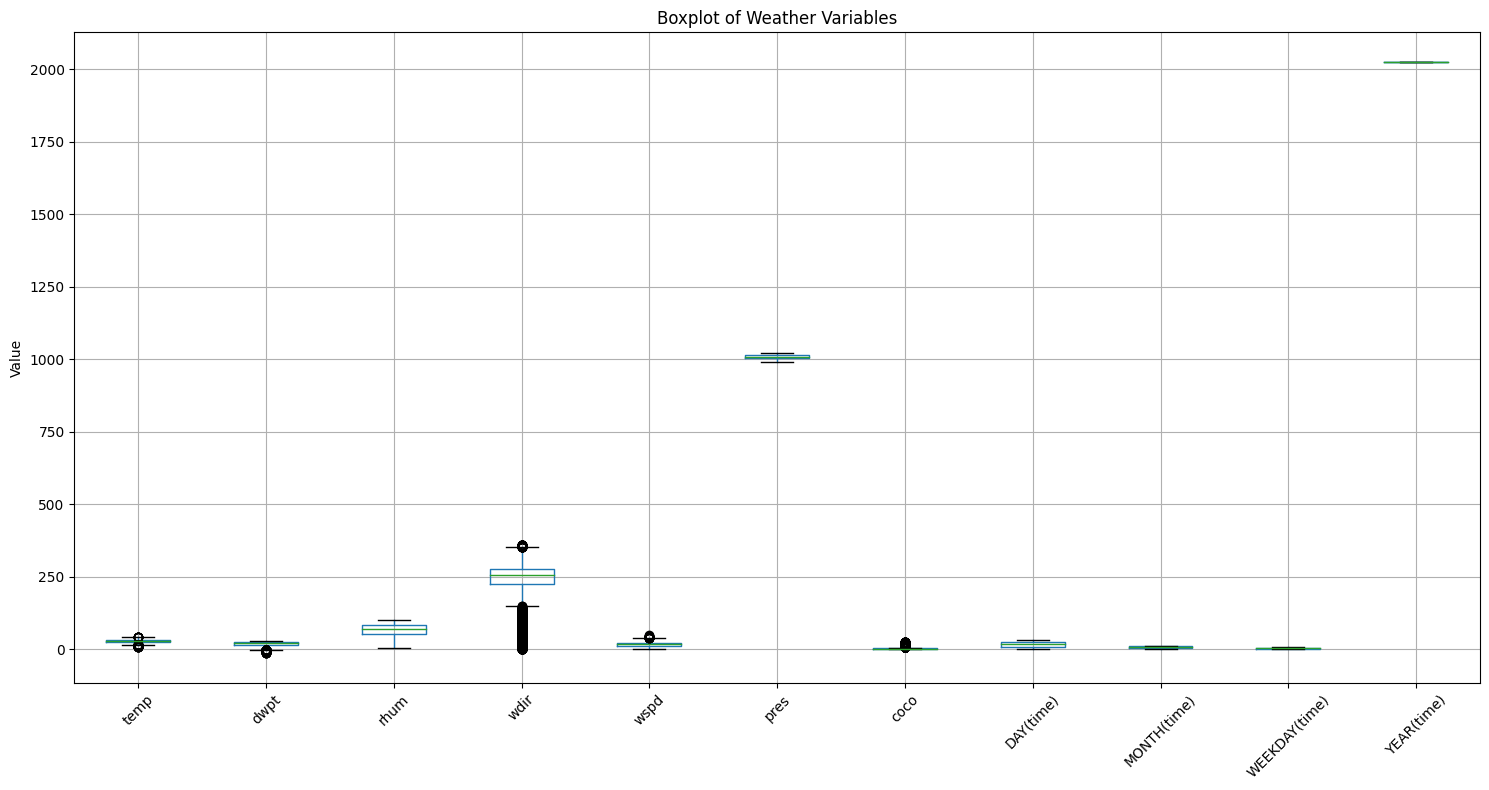

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt


# List of numerical columns 
numeric_cols = ['temp','dwpt','rhum','wdir','wspd','pres','coco','DAY(time)','MONTH(time)','WEEKDAY(time)','YEAR(time)']

# Create boxplot
plt.figure(figsize=(15, 8))
data[numeric_cols].boxplot()
plt.title('Boxplot of Weather Variables')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
data.describe()

temp         dwpt         rhum         wdir         wspd  \
count  8784.000000  8784.000000  8784.000000  8784.000000  8784.000000   
mean     26.612056    18.367851    65.346653   223.545196    17.725615   
std       5.809553     8.751519    22.406803    92.109801     7.063163   
min       7.700000   -14.100000     5.000000     0.000000     0.000000   
25%      23.500000    13.900000    51.000000   224.000000    12.200000   
50%      27.800000    22.500000    70.000000   254.000000    17.300000   
75%      30.600000    24.800000    84.000000   275.000000    22.700000   
max      42.700000    28.600000   100.000000   360.000000    49.700000   

              pres         coco    DAY(time)  MONTH(time)  WEEKDAY(time)  \
count  8784.000000  8784.000000  8766.000000  8766.000000    8766.000000   
mean   1008.173463     1.996015    15.729637     6.524298       2.990418   
std       6.887072     2.094784     8.800594     3.447501       2.003511   
min     990.800000     1.000000     1.000000     1.000000       0.000000   
25%    1003.100000     1.000000     8.000000     4.000000       1.000000   
50%    1008.700000     1.000000    16.000000     7.000000       3.000000   
75%    1013.800000     3.000000    23.000000    10.000000       5.000000   
max    1022.600000    25.000000    31.000000    12.000000       6.000000   

        YEAR(time)  
count  8766.000000  
mean   2024.323751  
std       0.467933  
min    2024.000000  
25%    2024.000000  
50%    2024.000000  
75%    2025.000000  
max    2025.000000

In [53]:
# Calling AQI data
# Constants
LAT = 24.8607
LON = 67.0011
MAX_DAYS = 92
END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=365)  # 1 year of data

all_data = []

# Break into 92-day chunks
current_start = START_DATE
while current_start < END_DATE:
    current_end = min(current_start + timedelta(days=MAX_DAYS), END_DATE)

    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": current_start.strftime("%Y-%m-%d"),
        "end_date": current_end.strftime("%Y-%m-%d"),
        "hourly[]": ["pm10", "pm2_5"]
    }

    response = requests.get("https://air-quality-api.open-meteo.com/v1/air-quality", params=params)
    data = response.json()

    if "hourly" in data and all(k in data["hourly"] for k in ["time", "pm10", "pm2_5"]):
        df = pd.DataFrame({
            "Timestamp": data["hourly"]["time"],
            "PM10": data["hourly"]["pm10"],
            "PM2_5": data["hourly"]["pm2_5"]
        })
        all_data.append(df)
        print(f"✅ Retrieved data from {current_start.date()} to {current_end.date()}")
    else:
        print(f"❌ Failed for range {current_start.date()} to {current_end.date()}")
        print(data)

    # Move to next chunk
    current_start = current_end + timedelta(days=1)

# Combine and save
if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    full_df.to_csv("karachi_aqi_full_year.csv", index=False)
    print(f"📦 Total records: {len(full_df)}")
    print("✅ Saved full dataset to 'karachi_aqi_full_year.csv'")
else:
    print("❌ No data collected.")




✅ Retrieved data from 2024-04-29 to 2024-07-30
✅ Retrieved data from 2024-07-31 to 2024-10-31
✅ Retrieved data from 2024-11-01 to 2025-02-01
✅ Retrieved data from 2025-02-02 to 2025-04-29
📦 Total records: 8784
✅ Saved full dataset to 'karachi_aqi_full_year.csv'


In [54]:
aqi=pd.read_csv("karachi_aqi_full_year.csv")
aqi

Timestamp   PM10  PM2_5
0     2024-04-29T00:00   61.5   21.8
1     2024-04-29T01:00   65.0   22.1
2     2024-04-29T02:00   72.2   23.9
3     2024-04-29T03:00   85.0   27.0
4     2024-04-29T04:00  135.0   29.0
...                ...    ...    ...
8779  2025-04-29T19:00   23.7   16.8
8780  2025-04-29T20:00   23.2   16.4
8781  2025-04-29T21:00   21.4   15.2
8782  2025-04-29T22:00   19.4   13.9
8783  2025-04-29T23:00   17.8   12.8

[8784 rows x 3 columns]

In [55]:
aqi = aqi.drop(aqi.columns[aqi.columns.str.contains('^Unnamed')], axis=1)
aqi.head()

Timestamp   PM10  PM2_5
0  2024-04-29T00:00   61.5   21.8
1  2024-04-29T01:00   65.0   22.1
2  2024-04-29T02:00   72.2   23.9
3  2024-04-29T03:00   85.0   27.0
4  2024-04-29T04:00  135.0   29.0

In [56]:
#Merging both dataset

weather_df = pd.read_csv("Karachi_weather_data.csv")
aqi_df = pd.read_csv("karachi_aqi_full_year.csv")  


weather_df['time'] = pd.to_datetime(weather_df['time'])
aqi_df['Timestamp'] = pd.to_datetime(aqi_df['Timestamp'])

merged_df = pd.merge(weather_df,aqi_df,left_on='time',right_on='Timestamp',how='left')

merged_df = merged_df.drop('Timestamp', axis=1)

merged_df.to_csv('weather_aqi_merged.csv', index=False)
print(merged_df.head(3))

                 time  temp  dwpt  rhum   wdir  wspd    pres  coco  id  \
0 2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1   0   
1 2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1   1   
2 2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1   2   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
0       29.0          4.0            0.0      2024.0  61.5   21.8  
1       29.0          4.0            0.0      2024.0  65.0   22.1  
2       29.0          4.0            0.0      2024.0  72.2   23.9  


In [57]:
data=pd.read_csv('weather_aqi_merged.csv')
data

time  temp  dwpt  rhum   wdir  wspd    pres  coco    id  \
0     2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1     0   
1     2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1     1   
2     2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1     2   
3     2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1     3   
4     2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1     4   
...                   ...   ...   ...   ...    ...   ...     ...   ...   ...   
8779  2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1  8779   
8780  2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1  8780   
8781  2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1  8781   
8782  2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1  8782   
8783  2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1  8783   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)   PM10  PM2_5  
0          29.0          4.0            0.0      2024.0   61.5   21.8  
1          29.0          4.0            0.0      2024.0   65.0   22.1  
2          29.0          4.0            0.0      2024.0   72.2   23.9  
3          29.0          4.0            0.0      2024.0   85.0   27.0  
4          29.0          4.0            0.0      2024.0  135.0   29.0  
...         ...          ...            ...         ...    ...    ...  
8779        NaN          NaN            NaN         NaN   23.7   16.8  
8780        NaN          NaN            NaN         NaN   23.2   16.4  
8781        NaN          NaN            NaN         NaN   21.4   15.2  
8782        NaN          NaN            NaN         NaN   19.4   13.9  
8783        NaN          NaN            NaN         NaN   17.8   12.8  

[8784 rows x 15 columns]

In [58]:
c_data=data.drop('id',axis=1,inplace=True)

In [59]:
data= data.drop(data.columns[data.columns.str.contains('^Unnamed')], axis=1)
data.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0  2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1   
1  2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1   
2  2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1   
3  2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1   
4  2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)   PM10  PM2_5  
0       29.0          4.0            0.0      2024.0   61.5   21.8  
1       29.0          4.0            0.0      2024.0   65.0   22.1  
2       29.0          4.0            0.0      2024.0   72.2   23.9  
3       29.0          4.0            0.0      2024.0   85.0   27.0  
4       29.0          4.0            0.0      2024.0  135.0   29.0

In [60]:
# Checking and Removing the Outliers

# list of features
weather_features = ['temp', 'dwpt', 'rhum','wdir', 'wspd', 'pres','coco', 'PM10', 'PM2_5','DAY(time)','MONTH(time)','WEEKDAY(time)','YEAR(time)','PM10','PM2_5'] 

# Making a copy
cleaned_data = data.copy()

# Creating a mask to keep original data
mask = np.ones(len(cleaned_data), dtype=bool)

for feature in weather_features:
    Q1 = cleaned_data[feature].quantile(0.25)
    Q3 = cleaned_data[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    feature_mask = (cleaned_data[feature] >= lower_bound) & (cleaned_data[feature] <= upper_bound)
    
    # Combining masks to keep only rows that are NOT outliers
    mask = mask & feature_mask

# Apply mask once at the end
cleaned_data = cleaned_data[mask]

# Final date check
print("Last date after cleaning:", cleaned_data['time'].max())


Last date after cleaning: 2025-04-29 05:00:00


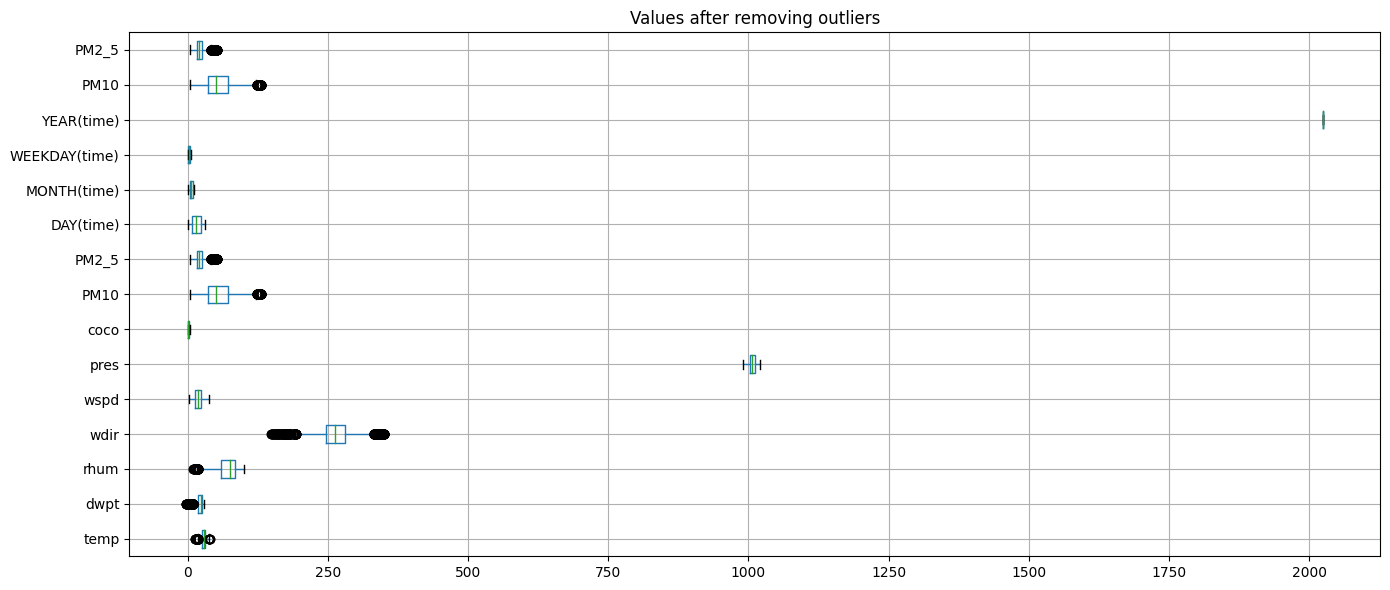

In [61]:
plt.figure(figsize=(14, 6))
cleaned_data.boxplot(column=weather_features, vert=False)
plt.title('Values after removing outliers')
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
cleaned_data.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
8761  2025-04-29 01:00:00  28.1  20.1  62.0  276.0  26.6  1002.9     1   
8762  2025-04-29 02:00:00  29.2  20.6  60.0  280.0  24.1  1003.8     1   
8763  2025-04-29 03:00:00  31.3  21.2  55.0  274.0  24.8  1004.2     1   
8764  2025-04-29 04:00:00  32.9  20.1  47.0  274.0  27.7  1004.7     1   
8765  2025-04-29 05:00:00  34.0  19.7  43.0  270.0  27.4  1005.0     1   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
8761       29.0          4.0            1.0      2025.0  11.9    8.8  
8762       29.0          4.0            1.0      2025.0  13.0   10.1  
8763       29.0          4.0            1.0      2025.0  17.7   13.4  
8764       29.0          4.0            1.0      2025.0  26.4   15.0  
8765       29.0          4.0            1.0      2025.0  34.3   16.5

In [63]:
cleaned_data.count()

time             6066
temp             6066
dwpt             6066
rhum             6066
wdir             6066
wspd             6066
pres             6066
coco             6066
DAY(time)        6066
MONTH(time)      6066
WEEKDAY(time)    6066
YEAR(time)       6066
PM10             6066
PM2_5            6066
dtype: int64

In [64]:
cleaned_data.to_csv('Karachi_Weather_aqi_Dataset.csv',index=False)
data=pd.read_csv('Karachi_Weather_aqi_Dataset.csv')
data

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0     2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1   
1     2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1   
2     2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1   
3     2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1   
4     2024-04-29 12:00:00  34.5   5.0  16.0  253.0  25.9  1007.5     1   
...                   ...   ...   ...   ...    ...   ...     ...   ...   
6061  2025-04-29 01:00:00  28.1  20.1  62.0  276.0  26.6  1002.9     1   
6062  2025-04-29 02:00:00  29.2  20.6  60.0  280.0  24.1  1003.8     1   
6063  2025-04-29 03:00:00  31.3  21.2  55.0  274.0  24.8  1004.2     1   
6064  2025-04-29 04:00:00  32.9  20.1  47.0  274.0  27.7  1004.7     1   
6065  2025-04-29 05:00:00  34.0  19.7  43.0  270.0  27.4  1005.0     1   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)   PM10  PM2_5  
0          29.0          4.0            0.0      2024.0   61.5   21.8  
1          29.0          4.0            0.0      2024.0   65.0   22.1  
2          29.0          4.0            0.0      2024.0   72.2   23.9  
3          29.0          4.0            0.0      2024.0   85.0   27.0  
4          29.0          4.0            0.0      2024.0  123.9   21.7  
...         ...          ...            ...         ...    ...    ...  
6061       29.0          4.0            1.0      2025.0   11.9    8.8  
6062       29.0          4.0            1.0      2025.0   13.0   10.1  
6063       29.0          4.0            1.0      2025.0   17.7   13.4  
6064       29.0          4.0            1.0      2025.0   26.4   15.0  
6065       29.0          4.0            1.0      2025.0   34.3   16.5  

[6066 rows x 14 columns]

In [65]:
# Rename date columns
data = data.rename(columns={
    'DAY(time)': 'Day',
    'MONTH(time)': 'Month',
    'WEEKDAY(time)': 'Weekday',
    'YEAR(time)': 'Year'
})

data = data.drop(columns=[col for col in ['Unnamed: 0'] if col in data.columns])


In [66]:
data['time'] = pd.to_datetime(data['time'])

In [67]:
data.dtypes

time       datetime64[ns]
temp              float64
dwpt              float64
rhum              float64
wdir              float64
wspd              float64
pres              float64
coco                int64
Day               float64
Month             float64
Weekday           float64
Year              float64
PM10              float64
PM2_5             float64
dtype: object

In [68]:
data.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
0 2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1  29.0   
1 2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1  29.0   
2 2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1  29.0   
3 2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1  29.0   
4 2024-04-29 12:00:00  34.5   5.0  16.0  253.0  25.9  1007.5     1  29.0   

   Month  Weekday    Year   PM10  PM2_5  
0    4.0      0.0  2024.0   61.5   21.8  
1    4.0      0.0  2024.0   65.0   22.1  
2    4.0      0.0  2024.0   72.2   23.9  
3    4.0      0.0  2024.0   85.0   27.0  
4    4.0      0.0  2024.0  123.9   21.7

In [69]:
data.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
6061 2025-04-29 01:00:00  28.1  20.1  62.0  276.0  26.6  1002.9     1  29.0   
6062 2025-04-29 02:00:00  29.2  20.6  60.0  280.0  24.1  1003.8     1  29.0   
6063 2025-04-29 03:00:00  31.3  21.2  55.0  274.0  24.8  1004.2     1  29.0   
6064 2025-04-29 04:00:00  32.9  20.1  47.0  274.0  27.7  1004.7     1  29.0   
6065 2025-04-29 05:00:00  34.0  19.7  43.0  270.0  27.4  1005.0     1  29.0   

      Month  Weekday    Year  PM10  PM2_5  
6061    4.0      1.0  2025.0  11.9    8.8  
6062    4.0      1.0  2025.0  13.0   10.1  
6063    4.0      1.0  2025.0  17.7   13.4  
6064    4.0      1.0  2025.0  26.4   15.0  
6065    4.0      1.0  2025.0  34.3   16.5

In [70]:

from google.oauth2 import service_account
from google.cloud import bigquery
from pandas_gbq import to_gbq

# Loading credentials
credentials = service_account.Credentials.from_service_account_file(
    r"C:\Users\Arbaz Aslam\arbaz-aslam-aqi-prediction-b20d9ef70aaf.json"
)

# Defining project and dataset info
project_id = "arbaz-aslam-aqi-prediction"
dataset_id = "aqi_feature_store"
table_id = "weather_aqi_features"

# Initializing BigQuery client
client = bigquery.Client(credentials=credentials, project=project_id)

# Making sure 'data' DataFrame is properly prepared
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')

# Uploading to BigQuery
to_gbq(
    data,
    destination_table=f"{dataset_id}.{table_id}",  # This should be dataset.table
    project_id=project_id,
    if_exists='replace',
    credentials=credentials
)


100%|██████████| 1/1 [00:00<?, ?it/s]


In [71]:
from pandas_gbq import read_gbq

query = """
SELECT *
FROM `arbaz-aslam-aqi-prediction.aqi_feature_store.weather_aqi_features`
ORDER BY time
"""
df_features = pd.read_gbq(query, project_id="arbaz-aslam-aqi-prediction", credentials=credentials)



In [72]:
df_features.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
0 2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1  29.0   
1 2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1  29.0   
2 2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1  29.0   
3 2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1  29.0   
4 2024-04-29 12:00:00  34.5   5.0  16.0  253.0  25.9  1007.5     1  29.0   

   Month  Weekday    Year   PM10  PM2_5  
0    4.0      0.0  2024.0   61.5   21.8  
1    4.0      0.0  2024.0   65.0   22.1  
2    4.0      0.0  2024.0   72.2   23.9  
3    4.0      0.0  2024.0   85.0   27.0  
4    4.0      0.0  2024.0  123.9   21.7

In [73]:
df_features.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco   Day  \
6061 2025-04-29 01:00:00  28.1  20.1  62.0  276.0  26.6  1002.9     1  29.0   
6062 2025-04-29 02:00:00  29.2  20.6  60.0  280.0  24.1  1003.8     1  29.0   
6063 2025-04-29 03:00:00  31.3  21.2  55.0  274.0  24.8  1004.2     1  29.0   
6064 2025-04-29 04:00:00  32.9  20.1  47.0  274.0  27.7  1004.7     1  29.0   
6065 2025-04-29 05:00:00  34.0  19.7  43.0  270.0  27.4  1005.0     1  29.0   

      Month  Weekday    Year  PM10  PM2_5  
6061    4.0      1.0  2025.0  11.9    8.8  
6062    4.0      1.0  2025.0  13.0   10.1  
6063    4.0      1.0  2025.0  17.7   13.4  
6064    4.0      1.0  2025.0  26.4   15.0  
6065    4.0      1.0  2025.0  34.3   16.5

In [80]:
df_features.describe()


temp         dwpt         rhum         wdir         wspd  \
count  6066.000000  6066.000000  6066.000000  6066.000000  6066.000000   
mean     28.114260    21.286614    70.043686   264.446093    19.001698   
std       4.083863     5.686787    19.758966    30.939435     6.730313   
min      13.800000    -2.400000    10.000000   148.000000     1.800000   
25%      25.900000    18.900000    59.000000   246.000000    13.700000   
50%      28.400000    23.500000    75.000000   262.000000    18.700000   
75%      30.800000    25.000000    85.000000   280.000000    24.100000   
max      40.400000    28.600000   100.000000   351.000000    37.800000   

              pres      coco          Day        Month      Weekday  \
count  6066.000000    6066.0  6066.000000  6066.000000  6066.000000   
mean   1006.893851  1.780086    15.463403     6.444939     2.979064   
std       5.865541  0.926538     8.578145     3.002338     1.989019   
min     990.800000       1.0     1.000000     1.000000     0.000000   
25%    1002.900000       1.0     8.000000     4.000000     1.000000   
50%    1007.200000       1.0    15.000000     6.000000     3.000000   
75%    1011.800000       3.0    23.000000     9.000000     5.000000   
max    1021.100000       5.0    31.000000    12.000000     6.000000   

              Year         PM10        PM2_5  
count  6066.000000  6066.000000  6066.000000  
mean   2024.306792    56.225849    22.176541  
std       0.461200    26.548431     7.992481  
min    2024.000000     3.900000     3.800000  
25%    2024.000000    37.000000    16.700000  
50%    2024.000000    49.900000    20.600000  
75%    2025.000000    71.200000    26.400000  
max    2025.000000   131.300000    52.900000

In [84]:

# Creating target columns for PM10 and PM2.5 for the next 3 days
for i in range(1, 4):
    df_features[f'PM10_day{i}'] = df_features['PM10'].shift(-i)
    df_features[f'PM2.5_day{i}'] = df_features['PM2_5'].shift(-i)

# Dropping rows with NaN values 
df_model = df_features.dropna().reset_index(drop=True)

# Defining feature and target columns
feature_cols = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco', 'Day', 'Month', 'Weekday', 'Year']
target_cols = [f'PM10_day{i}' for i in range(1, 4)] + [f'PM2.5_day{i}' for i in range(1, 4)]

X_raw = df_model[feature_cols] 
y_raw = df_model[target_cols]   

# Splitting into training and testing sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

# Scaling features and targets
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(X_train_raw)
X_test = X_scaler.transform(X_test_raw)

y_train = y_scaler.fit_transform(y_train_raw)
y_test = y_scaler.transform(y_test_raw)

# Saving the scalers
joblib.dump(X_scaler, "x_scaler.pkl")
joblib.dump(y_scaler, "y_scaler.pkl")

# Defining models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

# Hyperparameter grids
param_grids = {
    'RandomForest': {
        'estimator__n_estimators': [100, 200],
        'estimator__max_depth': [5, 10, 15],
        'estimator__min_samples_split': [2, 5]
    },
    'AdaBoost': {
        'estimator__n_estimators': [50, 100],
        'estimator__learning_rate': [0.01, 0.1, 1]
    },
    'XGBoost': {
        'estimator__n_estimators': [100, 200],
        'estimator__learning_rate': [0.01, 0.1, 0.2],
        'estimator__max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'estimator__n_estimators': [100, 200],
        'estimator__learning_rate': [0.01, 0.1],
        'estimator__max_depth': [5, 10],
        'estimator__num_leaves': [31, 50]
    },
    'CatBoost': {
        'estimator__iterations': [100, 200],
        'estimator__learning_rate': [0.01, 0.1],
        'estimator__depth': [5, 10]
    }
}

# Wrapping models with MultiOutputRegressor
wrapped_models = {name: MultiOutputRegressor(model) for name, model in models.items()}

# Store results
results = []
best_estimators = {}

# Training and tuning
for name, model in wrapped_models.items():
    print(f"🔍 Tuning {name}...")
    
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_estimators[name] = best_model

    preds_scaled = best_model.predict(X_test)
    preds = y_scaler.inverse_transform(preds_scaled)
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_unscaled, preds))
    mae = mean_absolute_error(y_test_unscaled, preds)
    r2 = r2_score(y_test_unscaled, preds)

    results.append((name, grid_search.best_params_, rmse, mae, r2))

# Display top 3 models
results.sort(key=lambda x: x[2])  # Sort by RMSE
top_3 = results[:3]

print("\n🏆 Top 3 Models (Lowest RMSE):")
for i, (name, best_params, rmse, mae, r2) in enumerate(top_3, 1):
    print(f"{i}. {name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.2f}, Best Params={best_params}")

# Train the final model
final_model_name = top_3[0][0]
final_model = best_estimators[final_model_name]

print(f"\n✅ Retraining final model: {final_model_name}")

# ⚡ IMPORTANT: Only transform, not fit_transform
final_model.fit(X_scaler.transform(X_raw), y_scaler.transform(y_raw))

# Save the final model
joblib.dump(final_model, "final_model.pkl")

# Predicting next 3 days
latest_features = df_model[feature_cols].iloc[[-1]]
latest_features_scaled = X_scaler.transform(latest_features)

future_preds_scaled = final_model.predict(latest_features_scaled)
future_preds = y_scaler.inverse_transform(future_preds_scaled)

# Creating DataFrame for easy viewing
columns = ['PM10_day1', 'PM10_day2', 'PM10_day3', 'PM2.5_day1', 'PM2.5_day2', 'PM2.5_day3']
future_df = pd.DataFrame(future_preds, columns=columns)

print("\n🔮 Predicted PM10 and PM2.5 for the Next 3 Days:")
print(future_df.T)


🔍 Tuning RandomForest...
🔍 Tuning AdaBoost...
🔍 Tuning XGBoost...
🔍 Tuning LightGBM...
🔍 Tuning CatBoost...

🏆 Top 3 Models (Lowest RMSE):
1. XGBoost: RMSE=8.53, MAE=5.25, R²=0.80, Best Params={'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 200}
2. CatBoost: RMSE=8.75, MAE=5.62, R²=0.79, Best Params={'estimator__depth': 10, 'estimator__iterations': 200, 'estimator__learning_rate': 0.1}
3. LightGBM: RMSE=8.79, MAE=5.52, R²=0.78, Best Params={'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__n_estimators': 200, 'estimator__num_leaves': 50}

✅ Retraining final model: XGBoost

🔮 Predicted PM10 and PM2.5 for the Next 3 Days:
                    0
PM10_day1   23.020546
PM10_day2   32.088596
PM10_day3   39.378380
PM2.5_day1  14.923960
PM2.5_day2  15.760246
PM2.5_day3  17.904270


In [85]:
# Predicting on the test set
preds_scaled = final_model.predict(X_test)
preds = y_scaler.inverse_transform(preds_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test)

# Creating a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual_PM10_day1': y_test_unscaled[:, 0],
    'Predicted_PM10_day1': preds[:, 0],
    'Actual_PM10_day2': y_test_unscaled[:, 1],
    'Predicted_PM10_day2': preds[:, 1],
    'Actual_PM10_day3': y_test_unscaled[:, 2],
    'Predicted_PM10_day3': preds[:, 2],
    'Actual_PM2.5_day1': y_test_unscaled[:, 3],
    'Predicted_PM2.5_day1': preds[:, 3],
    'Actual_PM2.5_day2': y_test_unscaled[:, 4],
    'Predicted_PM2.5_day2': preds[:, 4],
    'Actual_PM2.5_day3': y_test_unscaled[:, 5],
    'Predicted_PM2.5_day3': preds[:, 5]
})

# Displaying the comparison table (first 5 rows)
print("\nActual vs Predicted Values:")
print(comparison_df.head())



Actual vs Predicted Values:
   Actual_PM10_day1  Predicted_PM10_day1  Actual_PM10_day2  \
0              54.8            55.432552              49.4   
1             117.8           117.890724             116.6   
2              30.5            30.496273              30.0   
3              23.5            27.401737              21.3   
4              29.3            27.672291              27.1   

   Predicted_PM10_day2  Actual_PM10_day3  Predicted_PM10_day3  \
0            51.827908              43.0            46.424358   
1           119.406158             119.0           119.735054   
2            28.484255              30.4            26.907715   
3            27.698099              21.1            22.955545   
4            30.724813              25.8            28.930099   

   Actual_PM2.5_day1  Predicted_PM2.5_day1  Actual_PM2.5_day2  \
0               14.8             14.461709               13.8   
1               32.1             30.974392               32.1   
2           

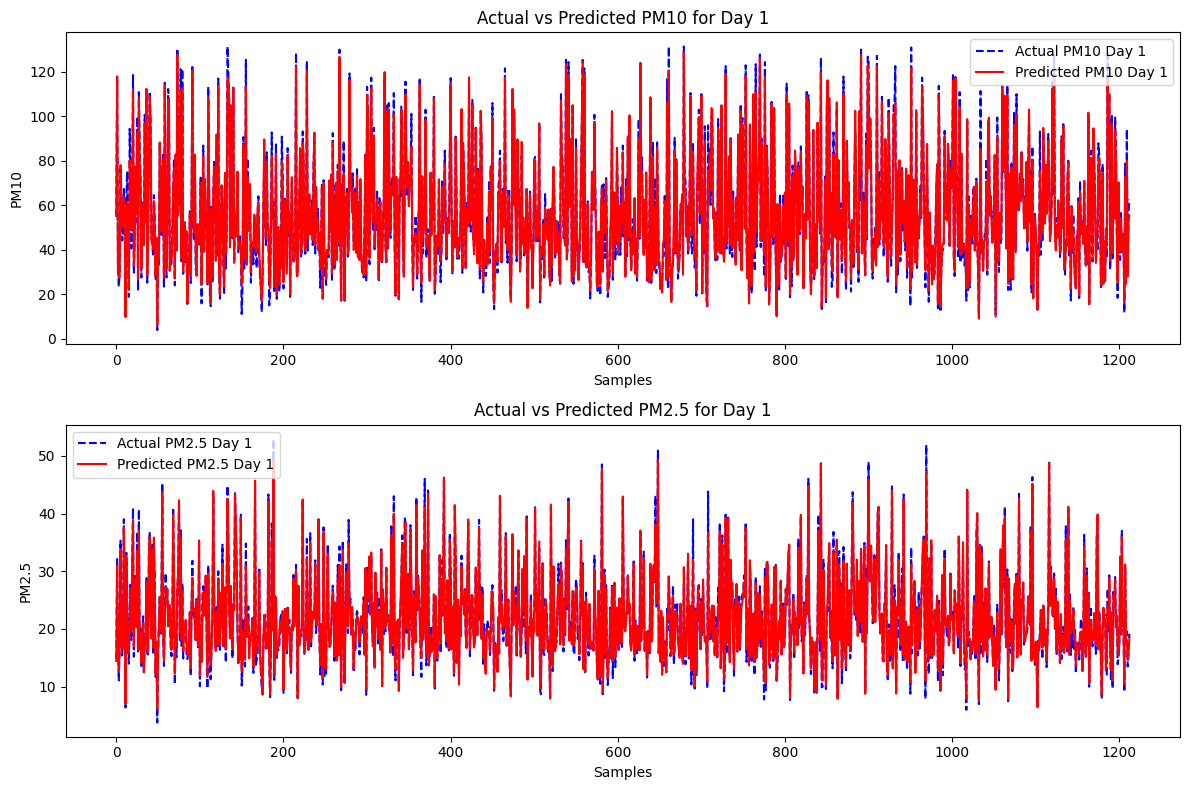

In [86]:

# Plotting Actual vs Predicted for PM10 and PM2.5 for day 1 (You can extend this for other days)
plt.figure(figsize=(12, 8))

# Plotting PM10 Day 1
plt.subplot(2, 1, 1)
plt.plot(comparison_df['Actual_PM10_day1'], label='Actual PM10 Day 1', color='blue', linestyle='dashed')
plt.plot(comparison_df['Predicted_PM10_day1'], label='Predicted PM10 Day 1', color='red', linestyle='solid')
plt.title('Actual vs Predicted PM10 for Day 1')
plt.xlabel('Samples')
plt.ylabel('PM10')
plt.legend()

# Plotting PM2.5 Day 1
plt.subplot(2, 1, 2)
plt.plot(comparison_df['Actual_PM2.5_day1'], label='Actual PM2.5 Day 1', color='blue', linestyle='dashed')
plt.plot(comparison_df['Predicted_PM2.5_day1'], label='Predicted PM2.5 Day 1', color='red', linestyle='solid')
plt.title('Actual vs Predicted PM2.5 for Day 1')
plt.xlabel('Samples')
plt.ylabel('PM2.5')
plt.legend()

plt.tight_layout()
plt.show()


In [93]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# 1. Set your experiment (it will create if it doesn't exist)
mlflow.set_experiment("AQI_Prediction_Experiment")

# 2. Start the MLflow run
with mlflow.start_run(run_name="XGBoost_Best_Model_Run"):

    # 3. Log parameters manually (optional but good practice)
    mlflow.log_params(top_3[0][1])  # log best hyperparameters
    
    # 4. Log metrics (optional)
    mlflow.log_metric("rmse", top_3[0][2])
    mlflow.log_metric("mae", top_3[0][3])
    mlflow.log_metric("r2", top_3[0][4])

    # 5. Ensure signature matches the feature columns used in training
    signature = infer_signature(X_train_raw, y_scaler.inverse_transform(final_model.predict(X_train_raw)))

    # 6. Save the model
    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path="xgboost_model",
        signature=signature,
        registered_model_name="AQI_XGBoost_Model"  # This will register the model
    )


G:\anaconda\envs\pycaret-env\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'AQI_XGBoost_Model'.
Created version '1' of model 'AQI_XGBoost_Model'.


In [95]:
print(type(final_model))


<class 'sklearn.multioutput.MultiOutputRegressor'>


In [97]:
import mlflow
print(mlflow.get_tracking_uri())
#line to loggedin in mlflow ui: 
#mlflow ui --backend-store-uri file:///C:/Users/Arbaz%20Aslam/Python%20work/Arbaz_Aslam_AQI_Project/mlruns

file:///C:/Users/Arbaz%20Aslam/Python%20work/Arbaz_Aslam_AQI_Project/mlruns
